# Stock Prediction Project

## by Zachary Wing

## Marathon Oil Corporation (MRO)

### Import

In [69]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('MRO.csv')

#print the head
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-06-04,26.879999,27.030001,26.639999,26.650000,24.674326,4377700
1,2015-06-05,26.540001,27.309999,26.500000,26.950001,24.952087,5321700
2,2015-06-08,26.790001,27.010000,26.440001,26.580000,24.609516,4697500
3,2015-06-09,26.870001,27.250000,26.730000,26.730000,24.748392,3281200
4,2015-06-10,27.150000,27.250000,26.940001,27.059999,25.053932,3405700


Data is last 5 years from 2015-06-03 to 2020-06-02

### Plotting the Figure

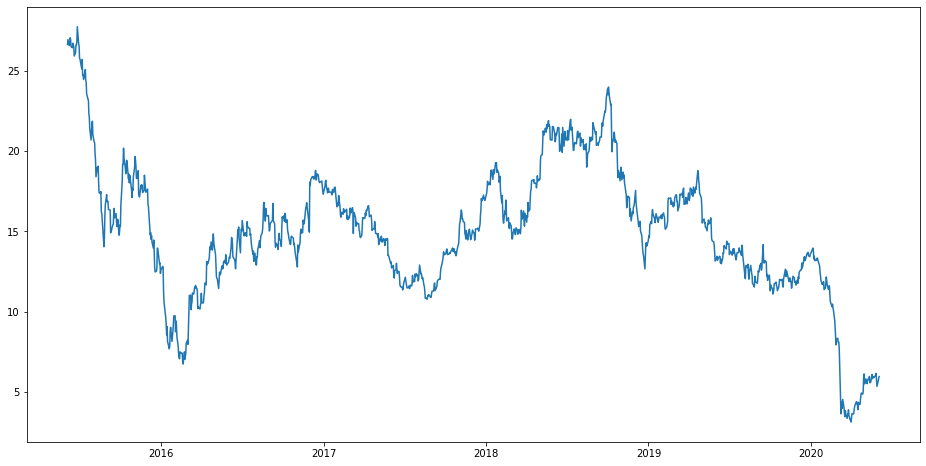

In [70]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

### Long Short Term Memory (LSTM)

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

The input gate: The input gate adds information to the cell state
The forget gate: It removes the information that is no longer required by the model
The output gate: Output Gate at LSTM selects the information to be shown as output




In [72]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [73]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1006,:]
valid = dataset[1006:,:]


In [74]:
#shapes of the original set
print('\n Shape of the original set:')
print(new_data.shape)

# shapes of training set
print('\n Shape of training set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of the original set:
(1259, 1)

 Shape of training set:
(1006, 1)

 Shape of validation set:
(253, 1)


In [75]:

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [76]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/1
 - 82s - loss: 0.0045


In [77]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.7127545438716012

/Users/zacharywing/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


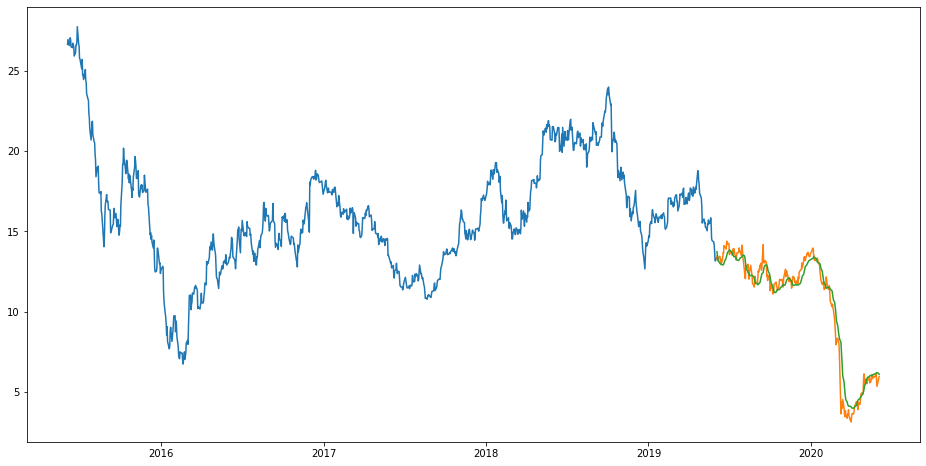

In [78]:
#for plotting

valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [79]:
train.head()

,Close
Date,
2015-06-04,26.65
2015-06-05,26.95
2015-06-08,26.58
2015-06-09,26.73
2015-06-10,27.06


In [80]:
valid.head()

,Close,Predictions
Date,,
2019-06-04,13.45,13.729897
2019-06-05,13.19,13.502345
2019-06-06,13.25,13.303530
2019-06-07,13.31,13.149489
2019-06-10,13.45,13.043683


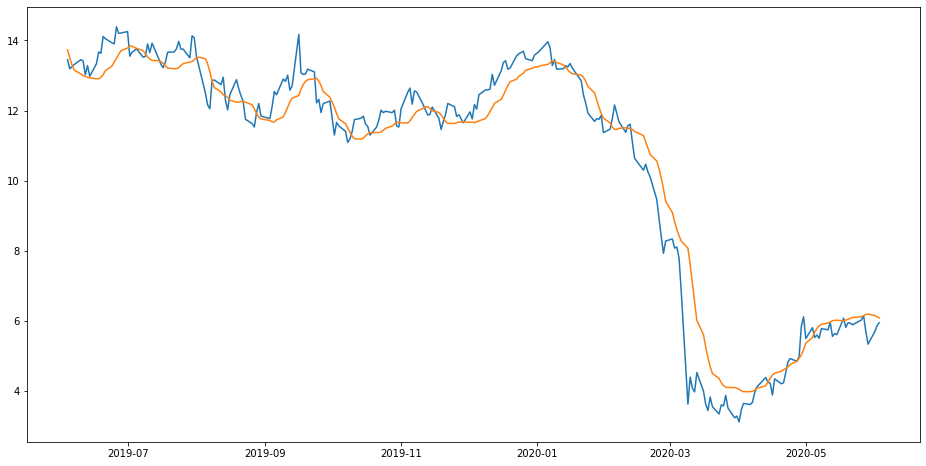

In [81]:
plt.figure(figsize=(16,8))
plt.plot(valid[['Close','Predictions']])

In [82]:
valid.to_csv('predictions.csv')

In [83]:
valid[['Predictions']].head()

,Predictions
Date,
2019-06-04,13.729897
2019-06-05,13.502345
2019-06-06,13.303530
2019-06-07,13.149489
2019-06-10,13.043683


In [84]:
valid[['Predictions']].max()


Predictions    13.848261
dtype: float32

In [85]:
print(valid[valid.Predictions == valid.Predictions.max()]) 

            Close  Predictions
Date                          
2019-07-02  13.55    13.848261


In [86]:
valid[['Predictions']].idxmax()

Predictions   2019-07-02
dtype: datetime64[ns]

In [87]:
valid_sub = valid.loc['2019-06-25':'2019-07-09']

In [88]:
valid_sub

,Close,Predictions
Date,,
2019-06-25,13.9,13.387714
2019-06-26,14.39,13.483858
2019-06-27,14.2,13.601700
2019-06-28,14.21,13.701689
2019-07-01,14.25,13.783072
2019-07-02,13.55,13.848261
2019-07-03,13.66,13.830001
2019-07-05,13.76,13.774006
2019-07-08,13.52,13.707312


In [89]:
train.tail()

,Close
Date,
2019-05-28,14.33
2019-05-29,14.09
2019-05-30,13.62
2019-05-31,13.15
2019-06-03,13.33


In [90]:
final_valid = valid_sub[['Predictions']]
final_valid.columns = ['Value']

final_valid = final_valid.sort_values(by='Value', ascending=False)
final_valid = final_valid[:1]

final = train
final.columns = ['Value']

final = final[-1:]

final_valid.head()

,Value
Date,
2019-07-02,13.848261


In [95]:

result = final.append(final_valid)
final.head()

,Value
Date,
2019-06-03,13.33


In [92]:
result

,Value
Date,
2019-06-03,13.33
2019-07-02,13.8483


In [93]:
result.to_csv('result.csv')

In [100]:
bvalue = result.Value[0]
evalue = result.Value[1]
pps = evalue-bvalue
roi = pps/bvalue
roip = roi*100
roip =round(roip,2)

from datetime import date
d0 = date(2019, 6, 3)
d1 = date(2019, 7, 2)
delta = d1 - d0

print('Begin Value: '+str(bvalue))
print('End Value: '+str(evalue))
print('Profit per Share: '+str(pps))
print('Return on Investment: '+str(roi))
print('Return on Investment: '+str(roip)+'%')
print('Number of Days: '+str(delta.days))

Begin Value: 13.33
End Value: 13.848260879516602
Profit per Share: 0.5182608795166015
Return on Investment: 0.03887928578519141
Return on Investment: 3.89%
Number of Days: 29


In [110]:
cash = 261.24
shares = np.floor(cash/bvalue)
investment = shares*bvalue
finalvalue = investment*(1+roi)
profit = finalvalue-investment


print('Number of Shares: '+str(shares))
print('Intial Investment: $'+str(investment))
print('Final Value: $'+str(finalvalue))
print('Profit: $'+str(profit))

Number of Shares: 19.0
Intial Investment: $253.27
Final Value: $263.11695671081543
Profit: $9.84695671081542
